## Required Libraries

In [3]:
import pandas as pd
import numpy as np


## Data Preprocessing

In [5]:
# Read only the first two columns
#df = pd.read_csv("Waste_3_6.csv", usecols=[0, 1])

df = pd.read_csv("Waste_3_6_July_Nov.csv", usecols=[0, 1])  ### new data set


# Rename columns
df.columns = ["Datetime", "Flow[cfs]"]

# Convert to datetime (auto-detects all formats)
df["Datetime"] = pd.to_datetime(df["Datetime"], errors="coerce")

# Convert flow values to numeric
df["Flow[cfs]"] = pd.to_numeric(df["Flow[cfs]"], errors="coerce")

# Drop invalid rows and set datetime index
df = df.dropna(subset=["Datetime"]).set_index("Datetime")

# Count how many have missing flow values
missing_points = df["Flow[cfs]"].isna().sum()

# Display first few rows
print(df.head())
print("Missing point",missing_points)


                     Flow[cfs]
Datetime                      
2025-07-18 17:08:00    0.45576
2025-07-18 17:18:00    0.47959
2025-07-18 17:28:00    0.47959
2025-07-18 17:38:00    0.44781
2025-07-18 17:48:00    0.40810
Missing point 0


### Resample into 10 min flow 

In [7]:
# Resample to a strict 10-minute grid and compute the mean per bin
flow_10min = df.resample("10min").mean()

### detecting and handliing outliers if any

In [9]:
# Compute quartiles
Q1 = flow_10min["Flow[cfs]"].quantile(0.25)
Q3 = flow_10min["Flow[cfs]"].quantile(0.75)
IQR = Q3 - Q1

# Bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = flow_10min[
    (flow_10min["Flow[cfs]"] < lower_bound) | 
    (flow_10min["Flow[cfs]"] > upper_bound)
]

print(f"Total outliers detected: {len(outliers)}")
print(f"Lower bound: {lower_bound:.3f}, Upper bound: {upper_bound:.3f}")

Total outliers detected: 0
Lower bound: 0.131, Upper bound: 1.018


In [11]:
flow_10min.loc[
    (flow_10min["Flow[cfs]"] < lower_bound) | 
    (flow_10min["Flow[cfs]"] > upper_bound), 
    "Flow[cfs]"
] = None

### Interpolate missing and outlier gaps (time-based)

In [13]:
# fill gaps smoothly if there are any using time-based interpolation
flow_10min = flow_10min.interpolate(method="time")

# Display first few rows
print(flow_10min.head())

                     Flow[cfs]
Datetime                      
2025-07-18 17:00:00    0.45576
2025-07-18 17:10:00    0.47959
2025-07-18 17:20:00    0.47959
2025-07-18 17:30:00    0.44781
2025-07-18 17:40:00    0.40810


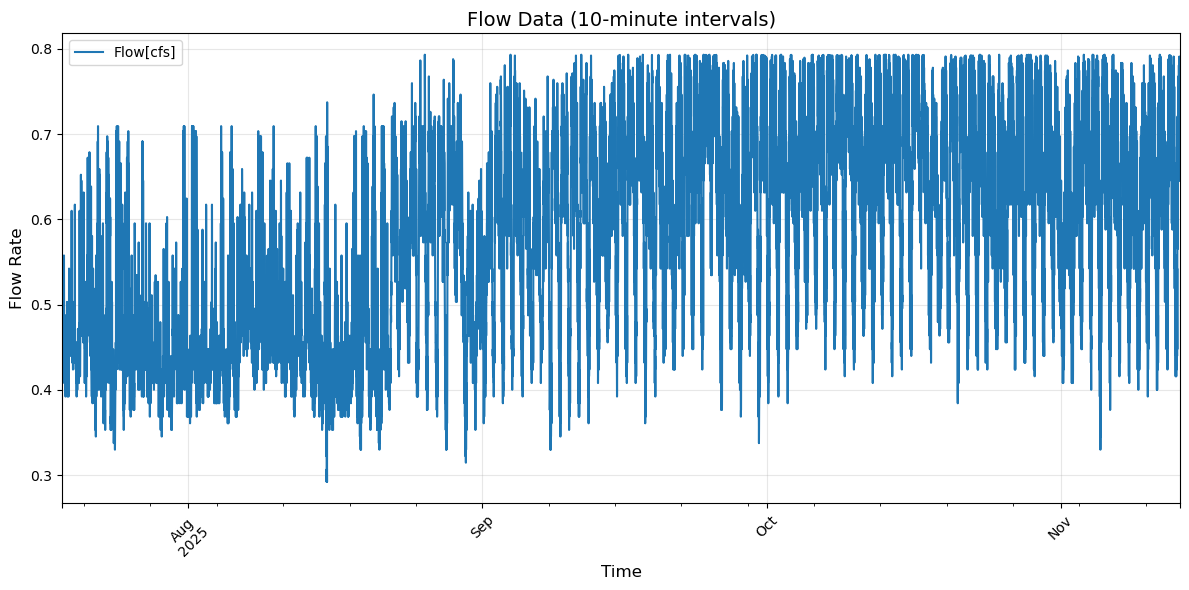

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Since I don't have access to your specific flow_10min DataFrame,
# I'll assume it contains time series data with a datetime index
# and one or more columns of flow measurements

# If your DataFrame is already defined, you can skip this part
# This is just an example of what the DataFrame might look like
# flow_10min = pd.DataFrame(your_data_here)

# Basic plotting of the entire DataFrame
fig, ax = plt.subplots(figsize=(12, 6))

# If flow_10min has multiple columns, this will plot all of them
flow_10min.plot(ax=ax)

# If you want to plot just one specific column, uncomment and modify this line:
# flow_10min['your_column_name'].plot(ax=ax)

# Enhance the plot with labels and title
plt.title('Flow Data (10-minute intervals)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Flow Rate', fontsize=12)
plt.grid(True, alpha=0.3)

# Add a legend if there are multiple columns
plt.legend(loc='best')

# Rotate x-axis labels if they're overlapping
plt.xticks(rotation=45)

# Adjust layout to prevent cut-off labels
plt.tight_layout()

# Display the plot
plt.show()

# ML Models

In [17]:
import numpy as np
import pandas as pd
import random
import math
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch import amp
import joblib # For saving the scaler

In [19]:
# -- Configuration
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Horizon and Lookback from your LSTM script
H, L = 18, 144  # 3-hour horizon (18 * 10 min), 24h lookback (144 * 10 min)

### Data Preparation

In [23]:
# This assumes `flow_10min` is a pandas DataFrame with a DatetimeIndex
# and a 'Flow[cfs]' column, already loaded and preprocessed.

df = flow_10min.copy().sort_index().asfreq('10min')
df['Flow[cfs]'] = df['Flow[cfs]'].interpolate(limit_direction='both')

### 70/15/15 split

In [25]:
N = len(df)
n_tr = int(0.70 * N)
n_va = int(0.15 * N)
train_df = df.iloc[:n_tr].copy()
val_df   = df.iloc[n_tr:n_tr+n_va].copy()
test_df  = df.iloc[n_tr+n_va:].copy()

### Feature Engineering & Scaling (using training set stats)

In [27]:
def daily_baseline(train_series, index_like):
    tod = (index_like.hour * 60 + index_like.minute) // 10
    group = (train_series.index.hour * 60 + train_series.index.minute) // 10
    base = train_series.groupby(group).median()
    return base.reindex(tod).values

train_df['Baseline'] = daily_baseline(train_df['Flow[cfs]'], train_df.index)
val_df['Baseline']   = daily_baseline(train_df['Flow[cfs]'], val_df.index)
test_df['Baseline']  = daily_baseline(train_df['Flow[cfs]'], test_df.index)

for d in (train_df, val_df, test_df):
    d['resid'] = d['Flow[cfs]'] - d['Baseline']
    d['resid_diff'] = d['resid'].diff().fillna(0.0)

def add_time_feats(d):
    h = d.index.hour + d.index.minute/60.0
    d['sin_h'] = np.sin(2*np.pi*h/24.0).astype('float32')
    d['cos_h'] = np.cos(2*np.pi*h/24.0).astype('float32')
    dow = d.index.dayofweek
    d['sin_d'] = np.sin(2*np.pi*dow/7.0).astype('float32')
    d['cos_d'] = np.cos(2*np.pi*dow/7.0).astype('float32')
    return d

train_df=add_time_feats(train_df); val_df=add_time_feats(val_df); test_df=add_time_feats(test_df)

SHIFT_24H = 24 * 6
for d in (train_df, val_df, test_df):
    d['resid_prevday'] = d['resid'].shift(SHIFT_24H)
    d.dropna(subset=['resid_prevday'], inplace=True)

scaler = StandardScaler().fit(train_df[['resid', 'resid_diff']].values)
for d in (train_df, val_df, test_df):
    d[['resid_z', 'resid_diff_z']] = scaler.transform(d[['resid', 'resid_diff']].values)

### Windowing & Dataloaders

In [29]:
def base_matrix(d):
    X = d[['resid_z', 'resid_diff_z', 'resid_prevday', 'sin_h', 'cos_h', 'sin_d', 'cos_d']].astype('float32').values
    return X, d['Baseline'].values.astype('float32')

def make_windows_mv(X, lookback=L, horizon=H):
    T=len(X); N=T-lookback-horizon+1
    if N<=0: return np.empty((0,lookback,X.shape[1]),'f'), np.empty((0,horizon),'f')
    s0,s1 = X.strides
    Xw = np.lib.stride_tricks.as_strided(X, (N,lookback,X.shape[1]), (s0,s0,s1)).copy()
    y  = np.lib.stride_tricks.as_strided(X[lookback:,0], (N,horizon), (s0,s0)).copy()
    return Xw, y

def future_time_feats(d, lookback=L, horizon=H):
    feats = d[['sin_h','cos_h','sin_d','cos_d']].astype('float32').values
    T=len(feats); N=T-lookback-horizon+1
    if N<=0: return np.empty((0,horizon,4),'f')
    s0,s1 = feats.strides
    return np.lib.stride_tricks.as_strided(feats[lookback:], (N,horizon,4), (s0,s0,s1)).copy()

def future_baseline(B, lookback=L, horizon=H):
    B=B.astype('float32'); T=len(B); N=T-lookback-horizon+1
    if N<=0: return np.empty((0,horizon),'f')
    s0=B.strides[0]
    return np.lib.stride_tricks.as_strided(B[lookback:], (N,horizon), (s0,s0)).copy()

Xtr,Btr = base_matrix(train_df); Xva,Bva = base_matrix(val_df); Xte,Bte = base_matrix(test_df)
X_train,y_train = make_windows_mv(Xtr,L,H); X_val,y_val = make_windows_mv(Xva,L,H); X_test,y_test = make_windows_mv(Xte,L,H)
F_train = future_time_feats(train_df,L,H); F_val = future_time_feats(val_df,L,H); F_test = future_time_feats(test_df,L,H)
BL_train = future_baseline(Btr,L,H); BL_val = future_baseline(Bva,L,H); BL_test = future_baseline(Bte,L,H)

class TripletDS(Dataset):
    def __init__(self,X,y,F,BL): self.X=torch.from_numpy(X); self.y=torch.from_numpy(y); self.F=torch.from_numpy(F); self.BL=torch.from_numpy(BL)
    def __len__(self): return len(self.X)
    def __getitem__(self,i): return self.X[i].float(), self.y[i].float(), self.F[i].float(), self.BL[i].float()

train_loader=DataLoader(TripletDS(X_train,y_train,F_train,BL_train), 128, shuffle=True)
val_loader  =DataLoader(TripletDS(X_val,y_val,F_val,BL_val), 256, shuffle=False)
test_loader =DataLoader(TripletDS(X_test,y_test,F_test,BL_test), 256, shuffle=False)

### 1D CNN Model

In [31]:
class CNN_Forecaster(nn.Module):
    def __init__(self, input_dim, horizon=H, channels=64):
        super().__init__()
        # PyTorch Conv1d expects input as (Batch, Channels, Length).
        # Our input_dim is the number of features, which will be the "Channels".
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=channels, kernel_size=7, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(channels)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=7, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(channels)
        )
        # Flatten the output and use a linear layer to predict the horizon
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * L, 128), # L is the lookback window size (144)
            nn.ReLU(),
            nn.Linear(128, horizon) # H is the horizon size (18)
        )

    def forward(self, x_hist, future_feats=None, y_teacher=None, tf_ratio=0.5):
        # We only need the history tensor 'x_hist' for the CNN
        # Permute from (Batch, Length, Channels) to (Batch, Channels, Length)
        x = x_hist.permute(0, 2, 1)
        
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        
        # The head flattens the output and predicts the horizon
        return self.head(x)

In [33]:
# input_dim is the number of features from your X_train array
input_dim = X_train.shape[2] 
model = CNN_Forecaster(input_dim=input_dim, horizon=H).to(device)

### Training Loop

In [35]:
## ===================== 5. Training Loop (Corrected for Deprecation Warning) =====================
import torch
from torch import nn
import numpy as np
# Use the modern top-level amp module for both autocast and GradScaler
from torch.amp import autocast, GradScaler

# -- Setup for training
use_amp = torch.cuda.is_available()
device_type = 'cuda' if use_amp else 'cpu'

# FIX: Use torch.amp.GradScaler and pass the device_type as the first argument
scaler_amp = GradScaler(device_type, enabled=use_amp)

opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=4, factor=0.5)
crit  = nn.MSELoss()

# -- Early stopping setup
best = np.inf
patience = 15
pat = 0
best_state = None
train_losses, val_losses = [], []

# -- Validation helper function
def eval_loader(dl):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb, Fb, BLb in dl:
            xb, yb, Fb = xb.to(device), yb.to(device), Fb.to(device)
            yhat = model(xb, Fb, None, 0.0)
            if yhat.ndim == 3 and yhat.shape[-1] == 1:
                yhat = yhat.squeeze(-1)
            loss = crit(yhat, yb)
            losses.append(loss.item())
    return float(np.mean(losses)) if losses else np.inf

# -- Main training loop
print("Starting 1D CNN model training...")
for ep in range(1, 150 + 1):
    model.train()
    tr = []
    for xb, yb, Fb, BLb in train_loader:
        xb, yb, Fb = xb.to(device), yb.to(device), Fb.to(device)
        opt.zero_grad(set_to_none=True)

        # Using the modern autocast context manager
        with autocast(device_type=device_type, enabled=use_amp):
            yhat = model(xb, Fb, y_teacher=yb, tf_ratio=0.5)
            if yhat.ndim == 3 and yhat.shape[-1] == 1:
                yhat = yhat.squeeze(-1)
            loss = crit(yhat, yb)

        scaler_amp.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler_amp.step(opt)
        scaler_amp.update()
        tr.append(loss.item())

    # --- Validation, scheduler step, and early stopping
    val_loss = eval_loader(val_loader)
    sched.step(val_loss)

    train_losses.append(np.mean(tr))
    val_losses.append(val_loss)
    print(f"Epoch {ep:03d} | Train Loss: {np.mean(tr):.6f} | Val Loss: {val_loss:.6f}")

    if val_loss < best - 1e-6:
        best = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1
        if pat >= patience:
            print(f"Early stopping at epoch {ep}.")
            break

# --- Load the best model found during training
if best_state is not None:
    print(f"\nLoading best model from epoch with validation loss: {best:.6f}")
    model.load_state_dict(best_state)
    model.to(device)

Starting 1D CNN model training...
Epoch 001 | Train Loss: 0.339596 | Val Loss: 0.299980
Epoch 002 | Train Loss: 0.245860 | Val Loss: 0.307874
Epoch 003 | Train Loss: 0.199696 | Val Loss: 0.326903
Epoch 004 | Train Loss: 0.156345 | Val Loss: 0.321977
Epoch 005 | Train Loss: 0.118525 | Val Loss: 0.353310
Epoch 006 | Train Loss: 0.091908 | Val Loss: 0.349733
Epoch 007 | Train Loss: 0.062400 | Val Loss: 0.345585
Epoch 008 | Train Loss: 0.047489 | Val Loss: 0.360375
Epoch 009 | Train Loss: 0.037888 | Val Loss: 0.360457
Epoch 010 | Train Loss: 0.032332 | Val Loss: 0.365031
Epoch 011 | Train Loss: 0.027792 | Val Loss: 0.369249
Epoch 012 | Train Loss: 0.020419 | Val Loss: 0.369644
Epoch 013 | Train Loss: 0.016617 | Val Loss: 0.375193
Epoch 014 | Train Loss: 0.014915 | Val Loss: 0.373979
Epoch 015 | Train Loss: 0.013075 | Val Loss: 0.371432
Epoch 016 | Train Loss: 0.011988 | Val Loss: 0.376618
Early stopping at epoch 16.

Loading best model from epoch with validation loss: 0.299980


### Evaluation on Test Set

In [37]:
def residz_to_flow(y_residz, BL):
    # Ensure arrays are 2D: [N, H]
    y_residz = y_residz.squeeze(-1) if y_residz.ndim == 3 else y_residz
    BL = BL.squeeze(-1) if BL.ndim == 3 else BL

    # The scaler was fit on ['resid', 'resid_diff'].
    # We only need the stats for the first feature ('resid') to inverse transform.
    resid = y_residz * scaler.scale_[0] + scaler.mean_[0]
    return resid + BL # Add the baseline back to get the final flow in cfs

# --- Get predictions on the test set
model.eval()
preds, truth, BLs = [], [], []
with torch.no_grad():
    for xb, yb, Fb, BLb in test_loader:
        xb, Fb = xb.to(device), Fb.to(device)
        yhat = model(xb, Fb, None, 0.0).cpu().numpy()
        preds.append(yhat)
        truth.append(yb.numpy())
        BLs.append(BLb.numpy())

y_pred_s = np.vstack(preds)
y_true_s = np.vstack(truth)
BL_arr   = np.vstack(BLs)

# Convert predictions back to original scale (cfs)
y_pred = residz_to_flow(y_pred_s, BL_arr)
y_true = residz_to_flow(y_true_s, BL_arr)

# --- Calculate and print metrics
def calculate_metrics(y_true, y_pred):
    mae_h = np.mean(np.abs(y_true - y_pred), axis=0)      # Per-horizon step
    rmse_h = np.sqrt(np.mean((y_true - y_pred)**2, axis=0)) # Per-horizon step
    mae_all = float(np.mean(np.abs(y_true - y_pred)))     # Overall
    rmse_all = float(np.sqrt(np.mean((y_true - y_pred)**2))) # Overall
    return mae_h, rmse_h, mae_all, rmse_all

mae_h, rmse_h, mae_all, rmse_all = calculate_metrics(y_true, y_pred)

print("\n=== Test Metrics (in cfs) ===")
for i in range(H):
    print(f"Horizon +{(i+1)*10:>3} min: MAE={mae_h[i]:.4f} | RMSE={rmse_h[i]:.4f}")
print(f"\nOverall MAE:  {mae_all:.4f} cfs")
print(f"Overall RMSE: {rmse_all:.4f} cfs")


=== Test Metrics (in cfs) ===
Horizon + 10 min: MAE=0.0433 | RMSE=0.0558
Horizon + 20 min: MAE=0.0485 | RMSE=0.0613
Horizon + 30 min: MAE=0.0483 | RMSE=0.0606
Horizon + 40 min: MAE=0.0472 | RMSE=0.0600
Horizon + 50 min: MAE=0.0492 | RMSE=0.0618
Horizon + 60 min: MAE=0.0497 | RMSE=0.0621
Horizon + 70 min: MAE=0.0474 | RMSE=0.0595
Horizon + 80 min: MAE=0.0499 | RMSE=0.0629
Horizon + 90 min: MAE=0.0491 | RMSE=0.0620
Horizon +100 min: MAE=0.0496 | RMSE=0.0620
Horizon +110 min: MAE=0.0518 | RMSE=0.0666
Horizon +120 min: MAE=0.0492 | RMSE=0.0627
Horizon +130 min: MAE=0.0485 | RMSE=0.0618
Horizon +140 min: MAE=0.0494 | RMSE=0.0617
Horizon +150 min: MAE=0.0486 | RMSE=0.0607
Horizon +160 min: MAE=0.0498 | RMSE=0.0632
Horizon +170 min: MAE=0.0521 | RMSE=0.0645
Horizon +180 min: MAE=0.0504 | RMSE=0.0635

Overall MAE:  0.0490 cfs
Overall RMSE: 0.0619 cfs


### Plotting a Test Sample

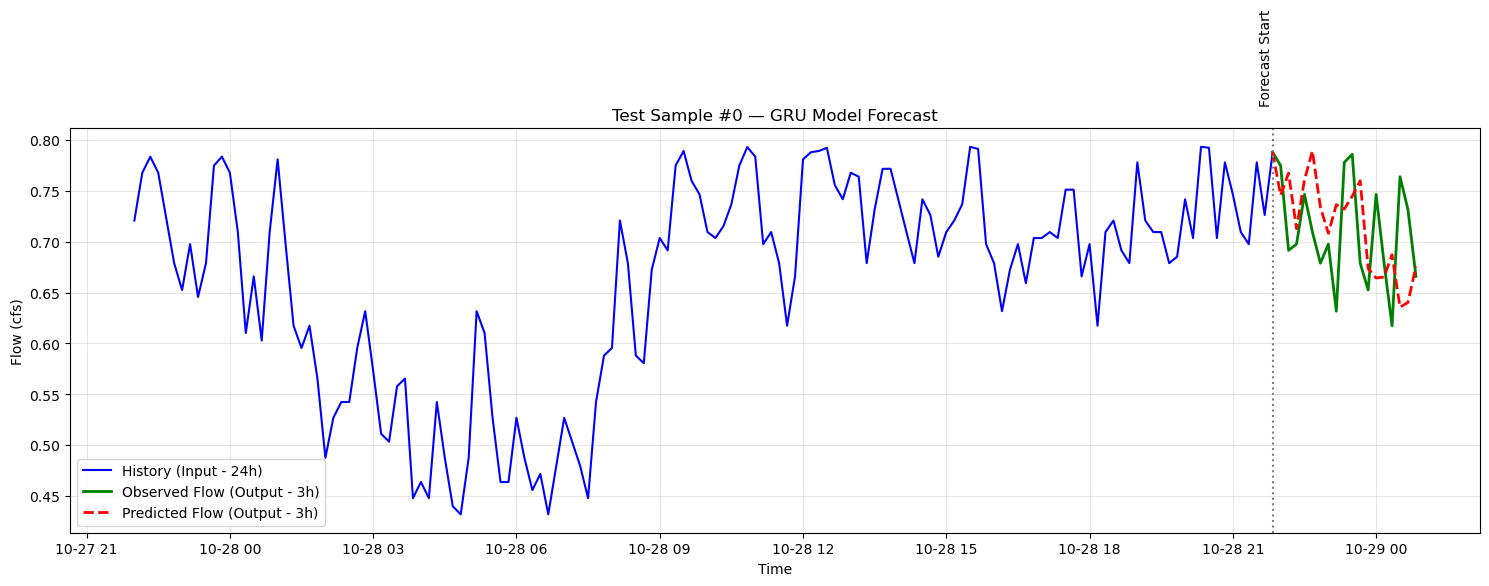

In [39]:
import matplotlib.pyplot as plt

test_series = test_df['Flow[cfs]']

def plot_test_sample(k=0):
    idx = test_series.index
    num_windows = len(idx) - L - H + 1
    k = max(0, min(k, num_windows-1)) # Ensure k is a valid index

    # Slices for history and future
    hist_slice = slice(k, k+L)
    fut_slice  = slice(k+L, k+L+H)
    hist_times, fut_times = idx[hist_slice], idx[fut_slice]
    hist_vals = test_series.iloc[hist_slice].values

    # To create continuous lines for plotting
    obs_time = np.concatenate([hist_times[-1:], fut_times])
    obs_vals = np.concatenate([hist_vals[-1:], y_true[k]])
    pred_time = np.concatenate([hist_times[-1:], fut_times])
    pred_vals = np.concatenate([hist_vals[-1:], y_pred[k]])

    plt.figure(figsize=(15, 6))
    plt.plot(hist_times, hist_vals, label="History (Input - 24h)", color='blue', lw=1.5)
    plt.plot(obs_time, obs_vals, label="Observed Flow (Output - 3h)", color='green', lw=2)
    plt.plot(pred_time, pred_vals, label="Predicted Flow (Output - 3h)", color='red', ls="--", lw=2)

    # Add a vertical line to mark the forecast start
    t_cut = hist_times[-1]
    ymax = max(hist_vals.max(), y_true[k].max()) * 1.05
    plt.axvline(t_cut, ls=':', color='gray')
    plt.text(t_cut, ymax, "Forecast Start", rotation=90, va="bottom", ha="right")

    plt.xlabel("Time")
    plt.ylabel("Flow (cfs)")
    plt.title(f"Test Sample #{k} — GRU Model Forecast")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot the first test sample
plot_test_sample(0)

# You can plot other samples by changing the index, e.g., plot_test_sample(100)

### Saving the Model and Scaler

In [41]:
# -- Save the PyTorch model state dictionary
model_save_path = "CNN_flow_model.pth"
torch.save(model.state_dict(), model_save_path)

# # -- Save the scikit-learn scaler object
# scaler_save_path = "flow_data_scaler.joblib"
# joblib.dump(scaler, scaler_save_path)

print(f"\n✅ Model state saved to: {model_save_path}")
#print(f"✅ Scaler saved to: {scaler_save_path}")


✅ Model state saved to: CNN_flow_model.pth
